**Dipole Moment**

In [1]:
from itertools import combinations
import numpy as np
from pyscf import gto
from jqc.mapper.jordan_wigner import JordanWignerMapper

def dipole_moment(mol):
    'Generate the dipole moment in the second quantization form.'
    coords = mol.atom_coords()
    no = 2
    second_q = ''
    for i, j in combinations(range(len(coords)), 2):
        r = np.linalg.norm(coords[i] - coords[j])
        second_q += f'+ {r} {j}^ {i} '
        second_q += f'+ {r} {j + no}^ {i + no} '
    print(second_q)
    return JordanWignerMapper(second_q)

mol = gto.M(atom='H 0 0 0; H 0 0 0.70', basis='sto-3g')

second_q = dipole_moment(mol)

print(second_q)

+ 1.322808287195543 1^ 0 + 1.322808287195543 3^ 2 
+ (0.330702071798886)i YXII + (0.330702071798886) XXII + (0.330702071798886) YYII - (0.330702071798886)i XYII + (0.330702071798886)i IIYX + (0.330702071798886) IIXX + (0.330702071798886) IIYY - (0.330702071798886)i IIXY 


**Transition Matrix element**

In [ ]:
from pyscf import gto
from jqc import VQE, VQD, SSVQE
from jqc.ansatz import eUCCSD
from jqc.simulator import QASM
from jqc.measure.dipole_moment import dipole_moment

from pyscf import gto
from jqc import VQE, VQD, SSVQE
from jqc.ansatz import eUCCSD

mol = gto.M(atom='H 0 0 0; H 0 0 0.70', basis='sto-3g')
ssvqe = SSVQE(mol, eUCCSD())
ssvqe.verbose = False

ssvqe.run()

# ssvqe.simulator = QASM()
dipole_moment = dipole_moment(ssvqe.profiles[0])
ssvqe.transition_matrix(dipole_moment)


**Molecular Spin Measure**

In [1]:
from pyscf import gto
from jqc import VQE, VQD
from jqc.ansatz import eUCCSD

mol = gto.M(atom='H 0 0 0; H 0 0 0.70', basis='sto-3g')
vqd = VQD(mol, eUCCSD())

vqd.run()


Starting VQD Calculation

Ansatz: eUCCSD
Simulator: StateVector
Optimizer: powell
nstates: 2

State 0:
Iteration: 97, Converged!!         
Total Energy: -1.136189454

State 1:
Iteration: 90, Converged!!         
Total Energy: -0.478453056

Final State Energies:
State 0: -1.136189454
State 1: -0.478453056

Elapsed time: 0:00:03


[Triplet_0, Triplet_1]

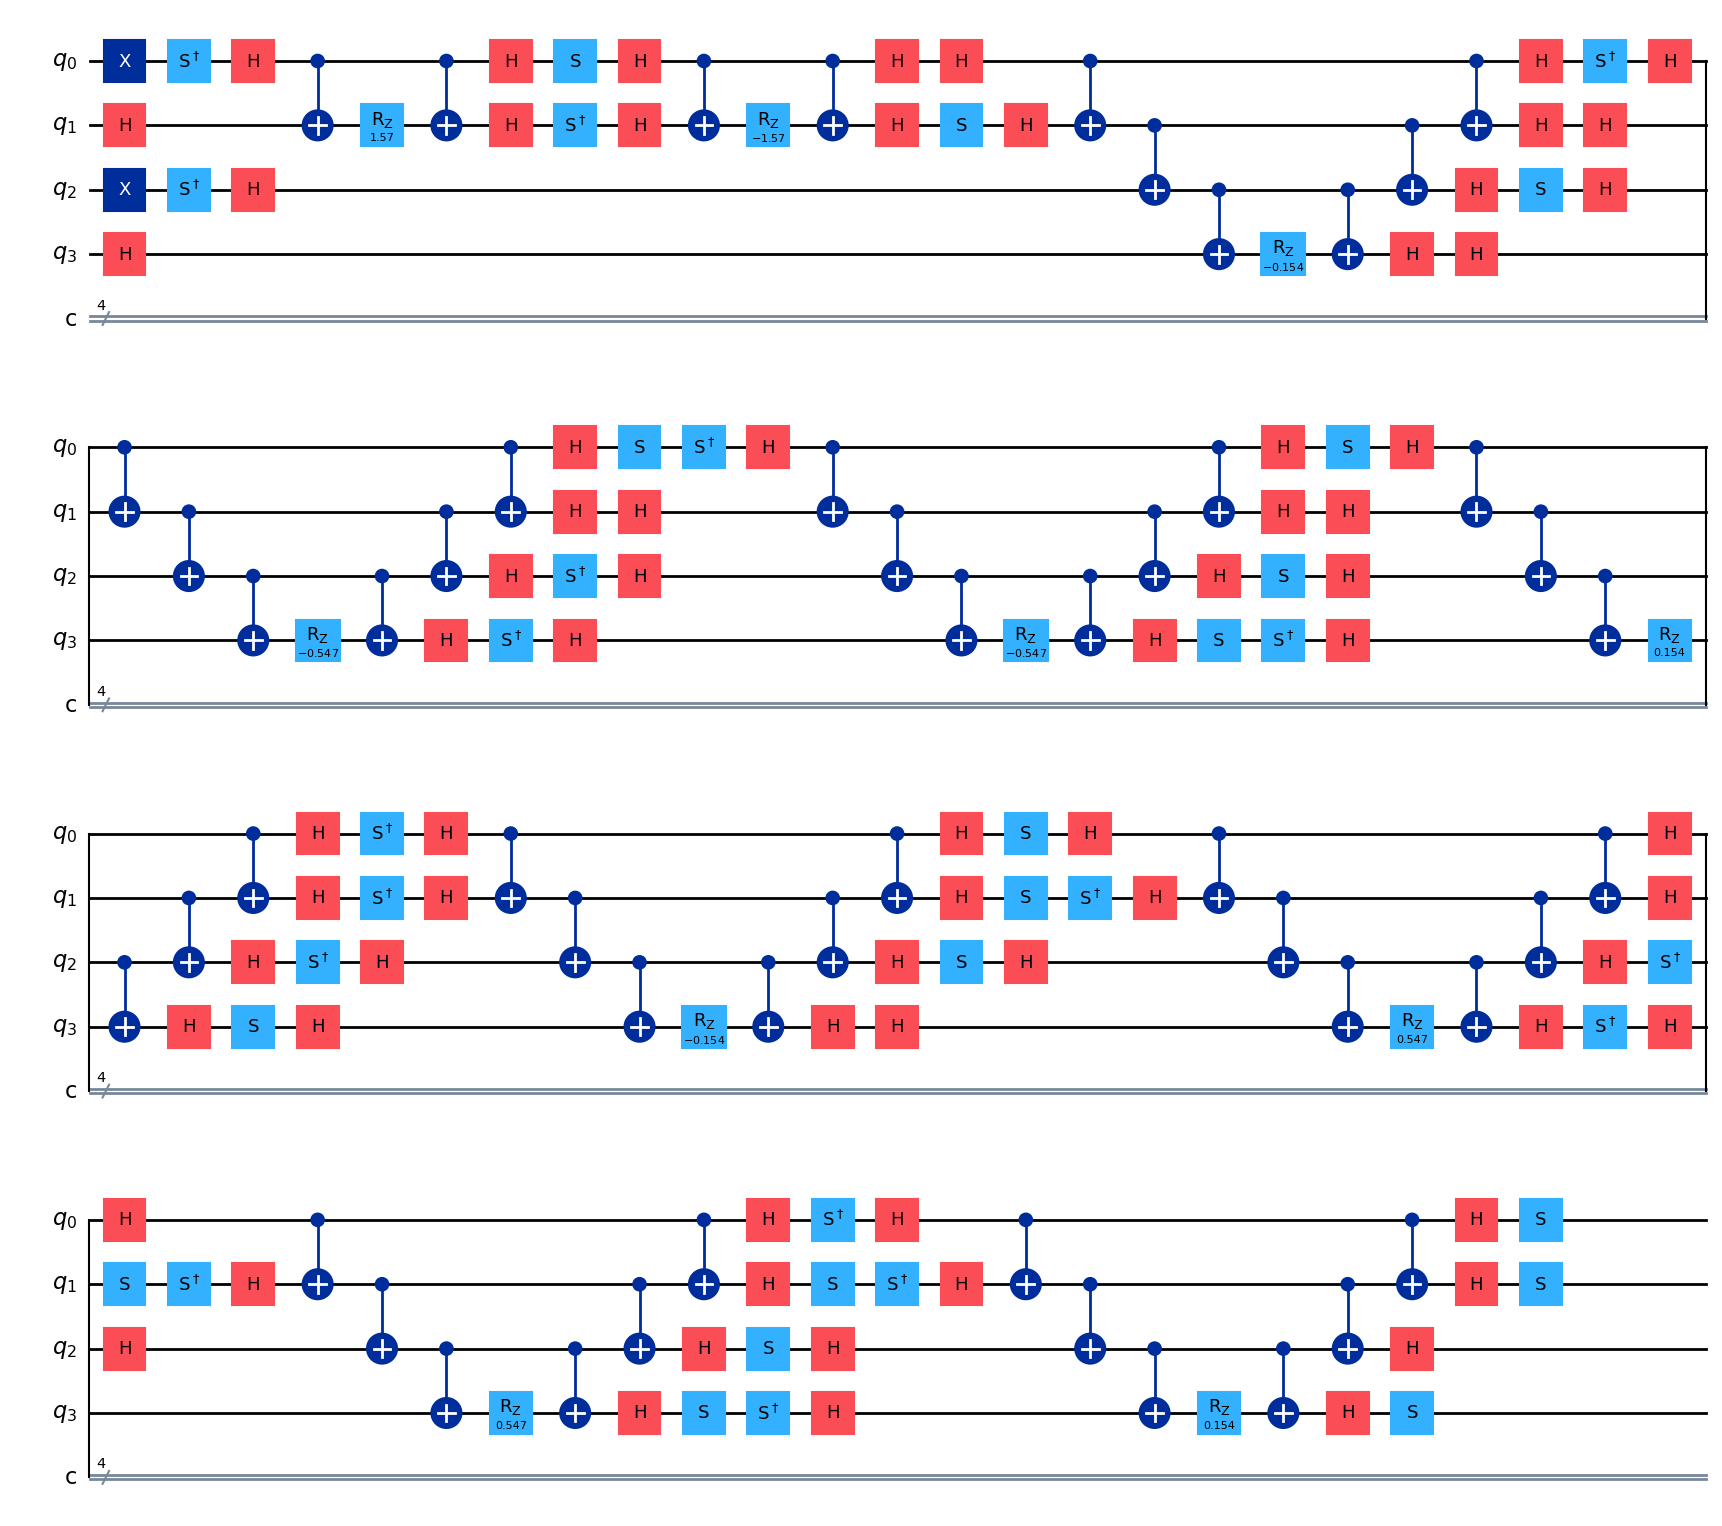

In [2]:
qc = vqd.profiles[1].circuit

qc.draw('mpl')